### demonstrating AprilTags  20221221 CJH
* found at least two libraries - apriltags and pupil-apriltags
* first needs cmake installed on windows, second has another issue
  * so pip fails on one, succeds on the other
* seems to be an issue loading pupil-apriltags on windows
  * dll issues cause problems with python 3.8+ and pupil_apiltags
  * for now I just made a 3.7 environment
* probably works just fine on linux / ras pi

#### import the necessary libraries

In [1]:
from pupil_apriltags import Detector  # apriltag processor
import cv2  # image acquisition and manipulation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# create a detector object
at_detector = Detector(
   families="tag16h5",
   nthreads=2,
   quad_decimate=1.0,
   quad_sigma=0.0,
   refine_edges=1,
   decode_sharpening=0.25,
   debug=0
)

In [3]:
# cameras I have calibrated  - note, it's all pretty wrong unless you use good tools
# format is [fx, fy, cx, cy]  - all in pixels
camera_params = {
    #'logitech_c290':[2589.21, 2570.98, 227.20, 228.82], # CJH office webcam
    #'ar0144_global_640': [991.45, 1858.11, 308.42, 215.05], # 640x480 opencv
    #'ar0144_global_640_calibdb': [810.62, 814.04, 335.25, 226.03], # 640x480 calibdb
    #'ar0144_global_320': [484.00, 978.61, 153.57, 104.20],  # 320x240
    'ms_lifecam_640': [956.70, 1268.96, 294.61, 257.27], # ms_lifecam #1 opencv
    #'ms_lifecam_320': [39.36, 156.22, 159.48, 119.50],  # ms_lifecam #1 opencv
    'ms_lifecam_640_calibdb': [747.01, 746.44, 320.48, 235.83], # ms_lifecam +1 calibdb - bad because of cropping
    'ms_lifecam_1280_calibdb': [1120.5, 1119.7, 640.1, 353.7], # ms_lifecam +1 calibdb
    'ms_lifecam_640_calculated': [684.7, 670.2, 320, 240], # ms_lifecam calculated from FoV
    'ms_lifecam_1280_calculated': [1104.1, 1104.7, 640, 360], # ms_lifecam calculated from FoV
    'ms_lifecam_640_3dfzephyr': [681.6, 681.6, 322.6, 243.8], # ms_lifecam 3DF zephyr
    'ms_lifecam_1280_3dfzephyr': [1142.9, 1142.9, 650.9, 354.7], # ms_lifecam 3DF zephyr
    'ms_lifecam_640_ros': [680.3, 685.8, 306.5, 244.6], # ms_lifecam ROS
    'ms_lifecam_1280_ros': [1080.8, 1076.8, 643.2, 351.3], # ms_lifecam ROS
    'ms_lifecam_640_opencv': [665.34, 1137.50, 321.62, 186.38]
    }
tag_size = 0.1524  # that's how many meters across we are

#### get an image from camera  - can be webcam or external USB
* you can skip this if you want to use the same image I did - it's saved on the disk; see below

In [13]:
resolution = (1280, 720)
cam = cv2.VideoCapture(1, cv2.CAP_DSHOW)  # open a regular USB cam
cam.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])
s, image_raw = cam.read()  # read from the camera
if s > 0:  # test if the camera actually returned a success
    #s, image_raw = cam.read()  # read from the camera
    cv2.imshow(f'Image Processing Pipeline', image_raw)
cam.release()
# close video display on key press
cv2.waitKey(0)
cv2.destroyAllWindows()

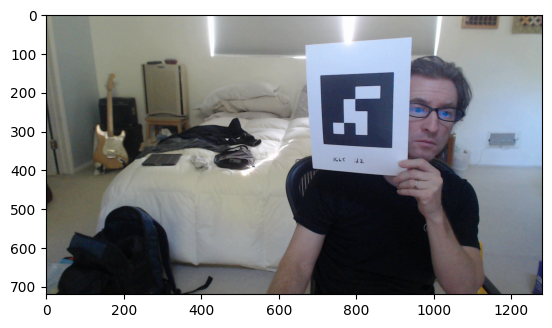

In [14]:
plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))

In [15]:
# in case we need it later
test_images = Path(".") / 'test_images'  # directory for the calibration images
# cal_images.absolute()
save_images = False
if save_images:
    plt.imsave(test_images / '16h5_test_1280_z4p00m.png', image_raw)
    # cv does not accept Paths
    cv_image = test_images / '16h5_test_cv_1280_z4p00m.png'
    cv2.imwrite(str(cv_image), image_raw)

In [16]:
# I want to keep looking at these images
load_images = False
if load_images:
    cv_image = test_images / '16h5_test_cv_1280_z4p00m.png'
    image_raw = cv2.imread(str(cv_image))

In [17]:
# this detector fails on color images
grey_image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)

In [18]:
%%time 
detections = at_detector.detect(grey_image)
detections = [det for det in detections if det.hamming < 2]

Wall time: 77.2 ms


In [19]:
%%time 
detections = at_detector.detect(grey_image, estimate_tag_pose=True, camera_params=camera_params['ms_lifecam_1280_calculated'], tag_size=tag_size)
detections2 = [det for det in detections if det.hamming < 2]
detections2

Wall time: 104 ms


[Detection object:
 tag_family = b'tag16h5'
 tag_id = 2
 hamming = 0
 decision_margin = 60.5988883972168
 homography = [[ 5.07677692e+01  3.06238074e+01  7.98896578e+02]
  [-1.18864247e+01  1.01827896e+02  2.50278944e+02]
  [-5.10166146e-02  3.67707104e-02  1.00000000e+00]]
 center = [798.89657777 250.2789442 ]
 corners = [[715.9052124  334.61804199]
  [893.0098877  345.13720703]
  [897.86138916 149.70700073]
  [707.42706299 158.08540344]]
 pose_R = [[ 0.91701389  0.05693167  0.39477122]
  [ 0.05425629  0.96275515 -0.26487501]
  [-0.3951478   0.26431288  0.87977095]]
 pose_t = [[ 0.13013255]
  [-0.08998864]
  [ 0.89541514]]
 pose_err = 1.2919193463695032e-05,
 Detection object:
 tag_family = b'tag16h5'
 tag_id = 12
 hamming = 1
 decision_margin = 0.2087731659412384
 homography = [[8.09833687e+01 7.83596842e+01 7.32209830e+02]
  [4.54279783e+01 3.88233982e+01 3.81880213e+02]
  [1.10338302e-01 1.11295705e-01 1.00000000e+00]]
 center = [732.20982961 381.88021331]
 corners = [[728.88830566

In [20]:
detections2[-1].pose_t[2][0]

14.98439311428451

In [34]:
detections2[-1].corners.flatten()

array([715.9052124 , 334.61804199, 893.0098877 , 345.13720703,
       897.86138916, 149.70700073, 707.42706299, 158.08540344])

In [35]:
detections2[-1].corners.reshape((-1, 1, 2))

array([[[715.9052124 , 334.61804199]],

       [[893.0098877 , 345.13720703]],

       [[897.86138916, 149.70700073]],

       [[707.42706299, 158.08540344]]])

#### looks like
* positive x means the tag is on the right
* negative y means the tag is above center
* positive z is obvious, it is the distance from the center of the camera

In [39]:
# process our image with the info from detector
def pipeline(img, intrinsics=None, tag_size=0.1524):
    img_copy = img.copy()
    grey_image = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    if intrinsics is None:
        detections = at_detector.detect(grey_image)
    else:
        detections = at_detector.detect(grey_image, estimate_tag_pose=True, camera_params=intrinsics, tag_size=tag_size)
    for idy, detection in enumerate(detections):
    
        color = ([255*int(i) for i in f'{(idy+1) % 7:03b}'])  # trick for unique colors
        center = [int(c) for c in detection.center]
        
        img_copy = cv2.putText(img_copy, f'{detection.tag_id:2d}', center, cv2.FONT_HERSHEY_SIMPLEX,1, color, 2) 
        
        corners = np.array([ [int (c) for c in corner] for corner in detection.corners ]).reshape((-1, 1, 2))
        # print(corners)
        img_copy = cv2.polylines(img_copy, [corners], isClosed=True, color=color, thickness=2)
  
    return img_copy, detections

In [40]:
# if you want to show the image with opencv as a separate window
cv2.imshow('Processed', pipeline(image_raw)[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

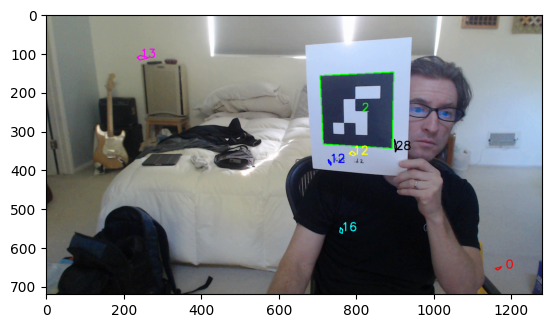

In [41]:
# show it with matplotlib instead
plt.imshow(cv2.cvtColor(pipeline(image_raw)[0], cv2.COLOR_BGR2RGB))

In [24]:
print('Summary of results')
for d in detections:
    print(f'ID: {d.tag_id:2}    hamming: {d.hamming}   decision_margin: {d.decision_margin:2.2f}')

Summary of results
ID:  0    hamming: 2   decision_margin: 0.52
ID:  2    hamming: 0   decision_margin: 60.60
ID: 12    hamming: 2   decision_margin: 0.10
ID: 12    hamming: 1   decision_margin: 0.21
ID: 13    hamming: 2   decision_margin: 0.51
ID: 16    hamming: 2   decision_margin: 0.40
ID: 28    hamming: 2   decision_margin: 0.19


In [25]:
for key, val in camera_params.items():
    if '640' in key:
        img_copy, detections = pipeline(image_raw, val)
        #print(val)
        detections2 = [det for det in detections if det.hamming < 1]
        d = detections2[-1]
        x,y,z = d.pose_t[0][0], d.pose_t[1][0] , d.pose_t[2][0]  
        print(f'{key[0:20]:22} ID: {d.tag_id:2}    hamming: {d.hamming}   margin: {d.decision_margin:2.2f}\
        xyz  {x:2.2f} {y:2.2f} {z:2.2f}')

ms_lifecam_640         ID:  2    hamming: 0   margin: 60.60        xyz  0.47 -0.00 0.90
ms_lifecam_640_calib   ID:  2    hamming: 0   margin: 60.60        xyz  0.40 0.01 0.62
ms_lifecam_640_calcu   ID:  2    hamming: 0   margin: 60.60        xyz  0.39 0.01 0.55
ms_lifecam_640_3dfze   ID:  2    hamming: 0   margin: 60.60        xyz  0.40 0.00 0.56
ms_lifecam_640_ros     ID:  2    hamming: 0   margin: 60.60        xyz  0.41 0.00 0.57
ms_lifecam_640_openc   ID:  2    hamming: 0   margin: 60.60        xyz  0.49 0.04 0.68


In [26]:
# with perspective, from the pose detected


#### tricks to get things to work

In [27]:
corners = [ [int (c) for c in corner] for corner in detections[1].corners ]
corners

[[715, 334], [893, 345], [897, 149], [707, 158]]

In [28]:
sorted(corners, key=lambda x: (x[1], x[0] ))

[[897, 149], [707, 158], [715, 334], [893, 345]]

In [29]:
# color trick
for ix in range(8):
    color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
    print(color, )

[0, 0, 255]
[0, 255, 0]
[0, 255, 255]
[255, 0, 0]
[255, 0, 255]
[255, 255, 0]
[0, 0, 0]
[0, 0, 255]


In [30]:
# getting corners for cv polylines
corners = np.array([ [int (c) for c in corner] for corner in detections[1].corners ])
corners.reshape((-1, 1, 2))

# corners = np.array([ [int (c) for c in corner] for corner in detections[1].corners ]).reshape((-1, 1, 2))
# img_copy = cv2.polylines(img_copy, [corners], isClosed=True, color=color, thickness=2)

array([[[715, 334]],

       [[893, 345]],

       [[897, 149]],

       [[707, 158]]])

In [31]:
# trying a manual corner sort that doesn't always work for drawing a box with lines
corners = [ [int (c) for c in corner] for corner in detections[1].corners ]
corners = sorted(corners, key=lambda x: (x[1]))  # sort from top to bottom
if (corners[0][0] > corners[1][0]) and (corners[2][0] > corners[3][0]):  # swap if 1st and 3rd on same side 
    corners[2], corners[3] = corners[3], corners[2]
corners
# for idx, corner in enumerate(corners):
#     img_copy = cv2.line(img_copy, corner, corners[(idx+1)%4], color, 2)

[[897, 149], [707, 158], [715, 334], [893, 345]]